<a href="https://colab.research.google.com/github/kuo8129/GenAI/blob/main/20250408HW_%E6%89%93%E9%80%A0RAG%E7%B3%BB%E7%B5%B1/20250408HW_%E6%89%93%E9%80%A0RAG%E7%B3%BB%E7%B5%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 安裝並引入套件

In [1]:
!pip install -U langchain langchain-community sentence-transformers faiss-cpu gradio openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.7/345.7 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 112.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/8

In [2]:
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.chat_models import ChatOpenAI
from langchain.chains import ConversationalRetrievalChain

In [3]:
from openai import OpenAI
import gradio as gr

# 讀入並解壓縮檔案

In [4]:
URL = "https://drive.google.com/uc?export=download&id=1fjcx9OX5mltmL16AprlwfreZv3sNIV1y"
!wget -O faiss_db.zip "$URL"

--2025-04-21 15:41:19--  https://drive.google.com/uc?export=download&id=1fjcx9OX5mltmL16AprlwfreZv3sNIV1y
Resolving drive.google.com (drive.google.com)... 74.125.141.113, 74.125.141.138, 74.125.141.100, ...
Connecting to drive.google.com (drive.google.com)|74.125.141.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1fjcx9OX5mltmL16AprlwfreZv3sNIV1y&export=download [following]
--2025-04-21 15:41:19--  https://drive.usercontent.google.com/download?id=1fjcx9OX5mltmL16AprlwfreZv3sNIV1y&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.139.132, 2607:f8b0:400c:c13::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.139.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 143265 (140K) [application/octet-stream]
Saving to: ‘faiss_db.zip’

faiss_db.zip        100%[===================>] 139.91K  --.-KB/s   

In [5]:
!unzip faiss_db.zip

Archive:  faiss_db.zip
   creating: faiss_db/
  inflating: faiss_db/index.pkl      
  inflating: faiss_db/index.faiss    


# 自訂 E5 embedding 類別
* 資料庫的內容前面加上 "passage:" 當前綴詞，以增加精準度
* 問題的前面加上 "query:" 當前綴詞，以增加精準度

In [6]:
class CustomE5Embedding(HuggingFaceEmbeddings):
    def embed_documents(self, texts):
        texts = [f"passage: {t}" for t in texts]
        return super().embed_documents(texts)

    def embed_query(self, text):
        return super().embed_query(f"query: {text}")

# 載入向量資料庫及原本的模型

In [7]:
embedding_model = CustomE5Embedding(model_name="intfloat/multilingual-e5-small")
db = FAISS.load_local("faiss_db", embedding_model, allow_dangerous_deserialization=True)
retriever = db.as_retriever()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/498k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

# LLM 設置
* 使用 Groq 的 API key
* 使用 OpenAI 的 API 來打造對話機器人

In [8]:
import os
from google.colab import userdata

In [9]:
api_key = userdata.get('Groq')

In [10]:
os.environ["OPENAI_API_KEY"] = api_key

In [11]:
model = "llama3-70b-8192"
base_url="https://api.groq.com/openai/v1"

In [12]:
client = OpenAI(
    base_url=base_url
)

# Prompt 設計
* 根據性平三法的資料回答問題
* 若資料不足可參閱全國法規資料庫

In [13]:
system_prompt = """
請用台灣熟悉的中文回應
你是一位熟悉台灣性平三法(性別平等教育法、性騷擾防治法、性別工作平等法)的法律顧問，請根據資料來回應諮詢者的問題。
請以專業、精準、簡潔的口吻來回應，必要時可引用原文或摘要，並請附上法規名稱、條文、條號。
請避免揣測或過度延伸，僅根據資料內容回答，若你找不到資料，請誠實告知詢問者。
請先將你的回應翻譯成繁體中文再顯示出來。
"""

prompt_template = """
根據下列資料回答問題：
{retrieved_chunks}

諮詢者的問題是：{question}

請根據資料內容回覆，若資料不足請告訴諮詢者可進一步參閱全國法規資料庫。
"""

# 使用 RAG 來回應

* 搜尋與輸入問題相關的資訊
* 根據 `prompt_template` 回應

In [14]:
chat_history = []

def chat_with_rag(user_input):
    global chat_history
    # 取回相關資料
    docs = retriever.get_relevant_documents(user_input)
    retrieved_chunks = "\n\n".join([doc.page_content for doc in docs])

    # 將自定 prompt 套入格式
    final_prompt = prompt_template.format(retrieved_chunks=retrieved_chunks, question=user_input)

    # 呼叫 OpenAI API
    response = client.chat.completions.create(
    model=model,
    messages=[
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": final_prompt},
    ])
    answer = response.choices[0].message.content

    chat_history.append((user_input, answer))
    return answer

# 用 Gradio 展示

In [15]:
title = "AI 法律顧問"
description = """
對性平法有疑問、不知道該看哪一條嗎？
AI 法律顧問可以幫您從《性騷擾防治法》、《性別平等工作法》和《性別平等教育法》中找出相關的法條內容。
只要輸入您的問題，就能快速找到對應的法條內容，協助您更清楚了解自身的權益與保障。
"""

In [16]:
with gr.Blocks() as demo:
    gr.Markdown(f"# 🏛️ {title}\n{description}")
    chatbot = gr.Chatbot(label="性平三法")
    msg = gr.Textbox(placeholder="請輸入你的問題...")

    def respond(message, chat_history_local):
        response = chat_with_rag(message)
        chat_history_local.append((message, response))
        return "", chat_history_local

    msg.submit(respond, [msg, chatbot], [msg, chatbot])

demo.launch(debug=True)

<ipython-input-16-03bb80ef440f>:3: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(label="性平三法")


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://a21ba20bef7e753d73.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


<ipython-input-14-381804e276c7>:6: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(user_input)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://a21ba20bef7e753d73.gradio.live


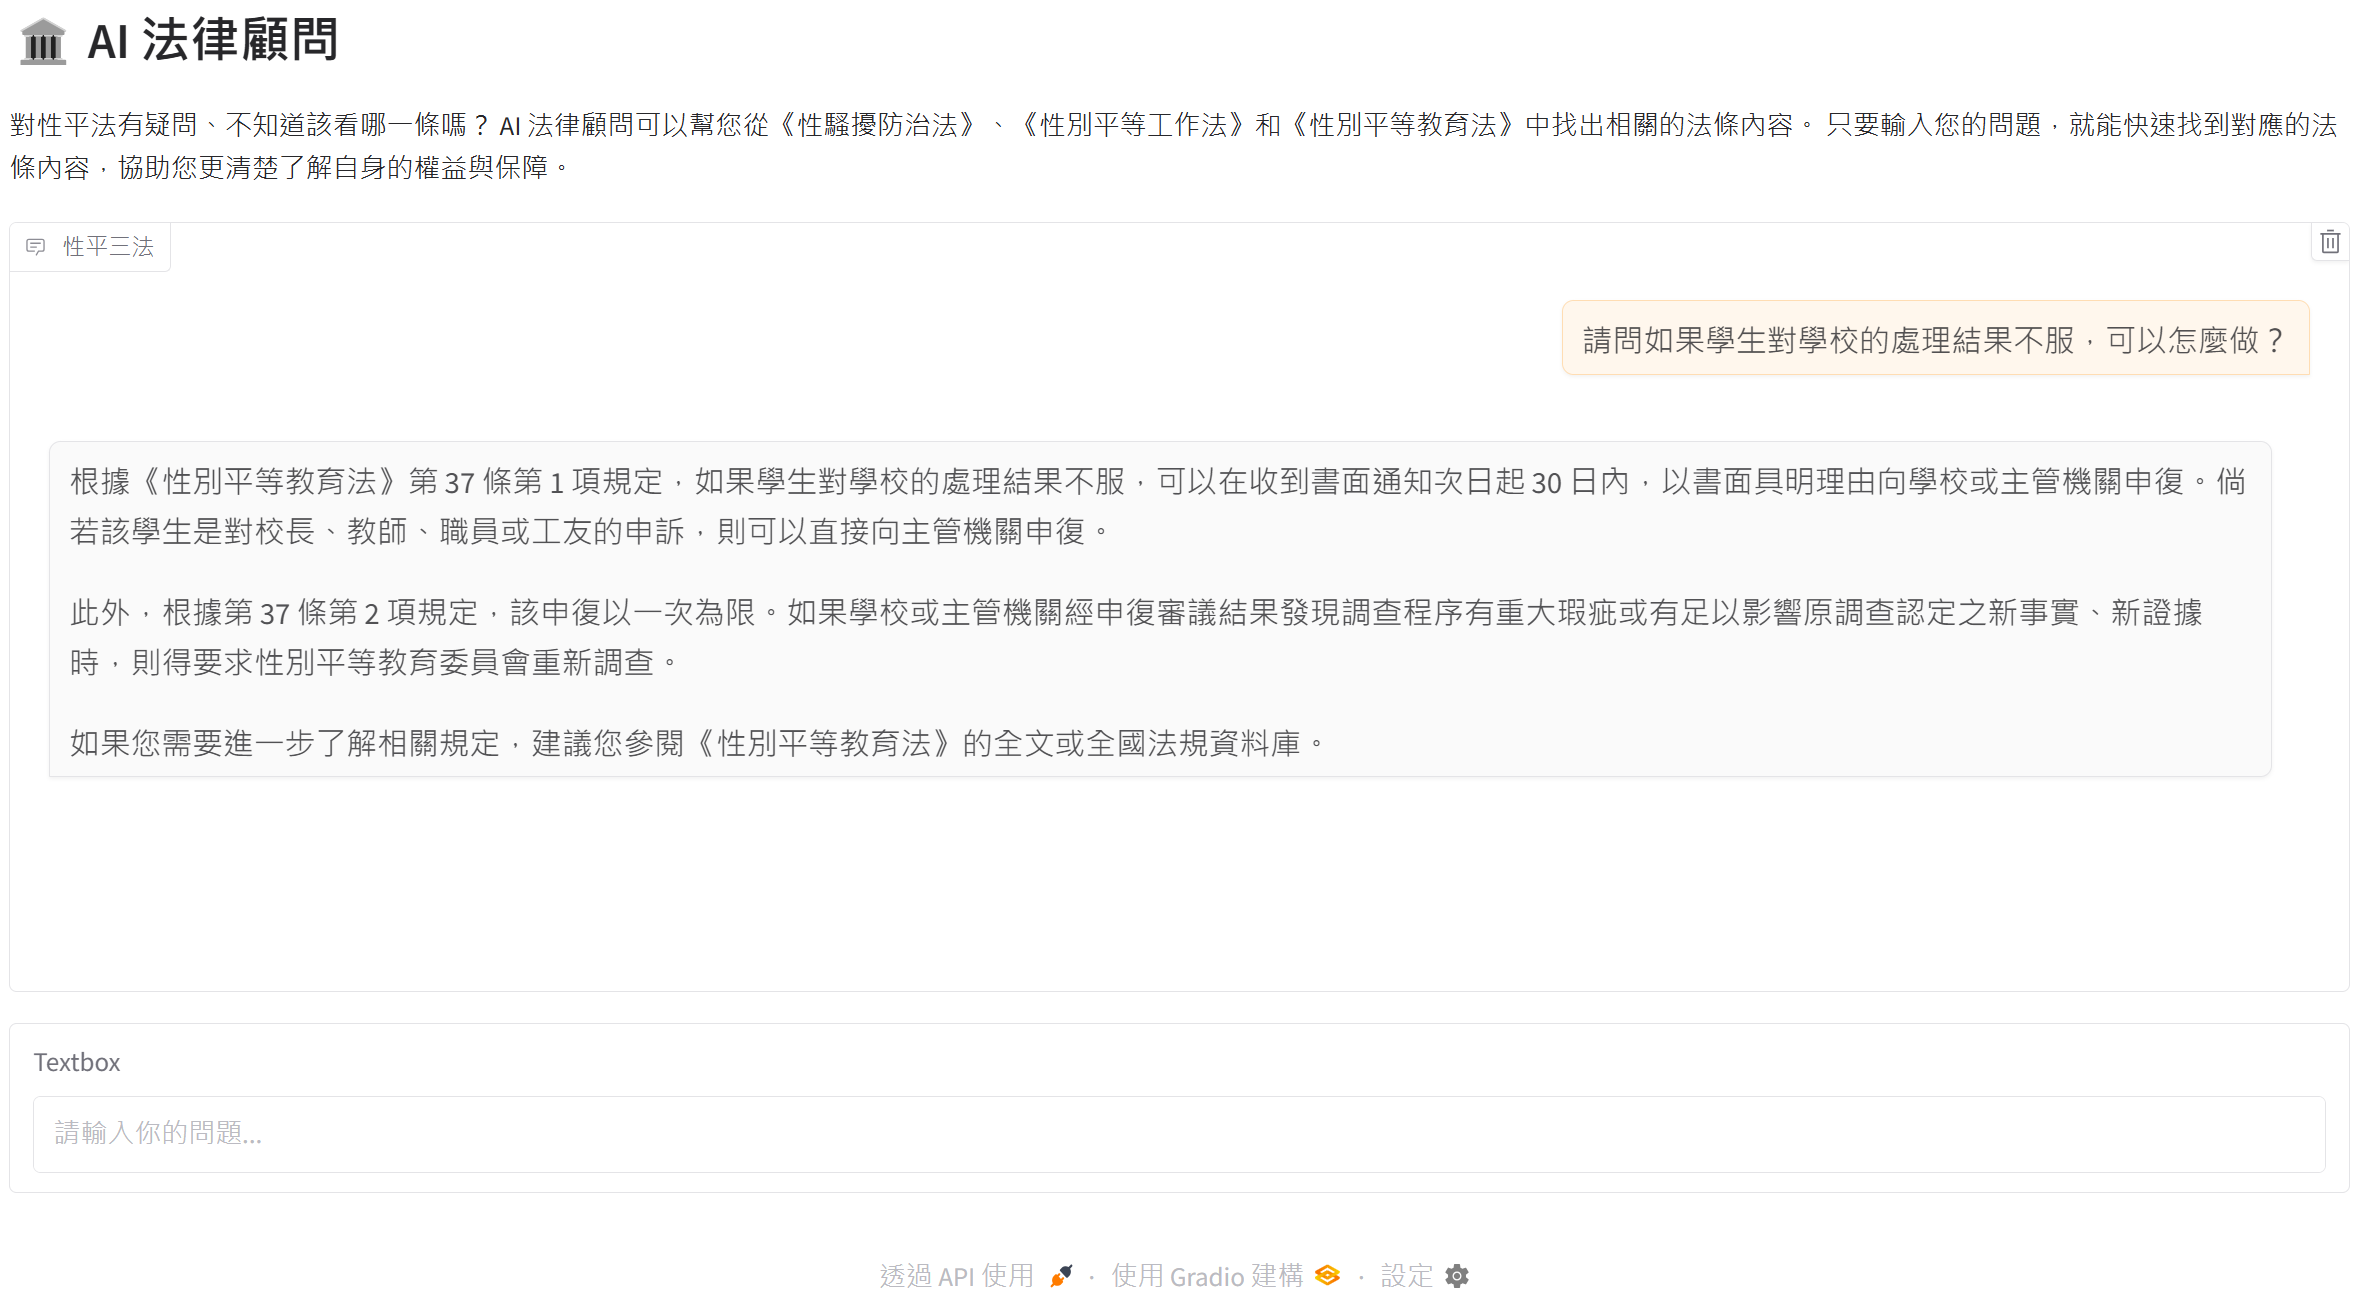

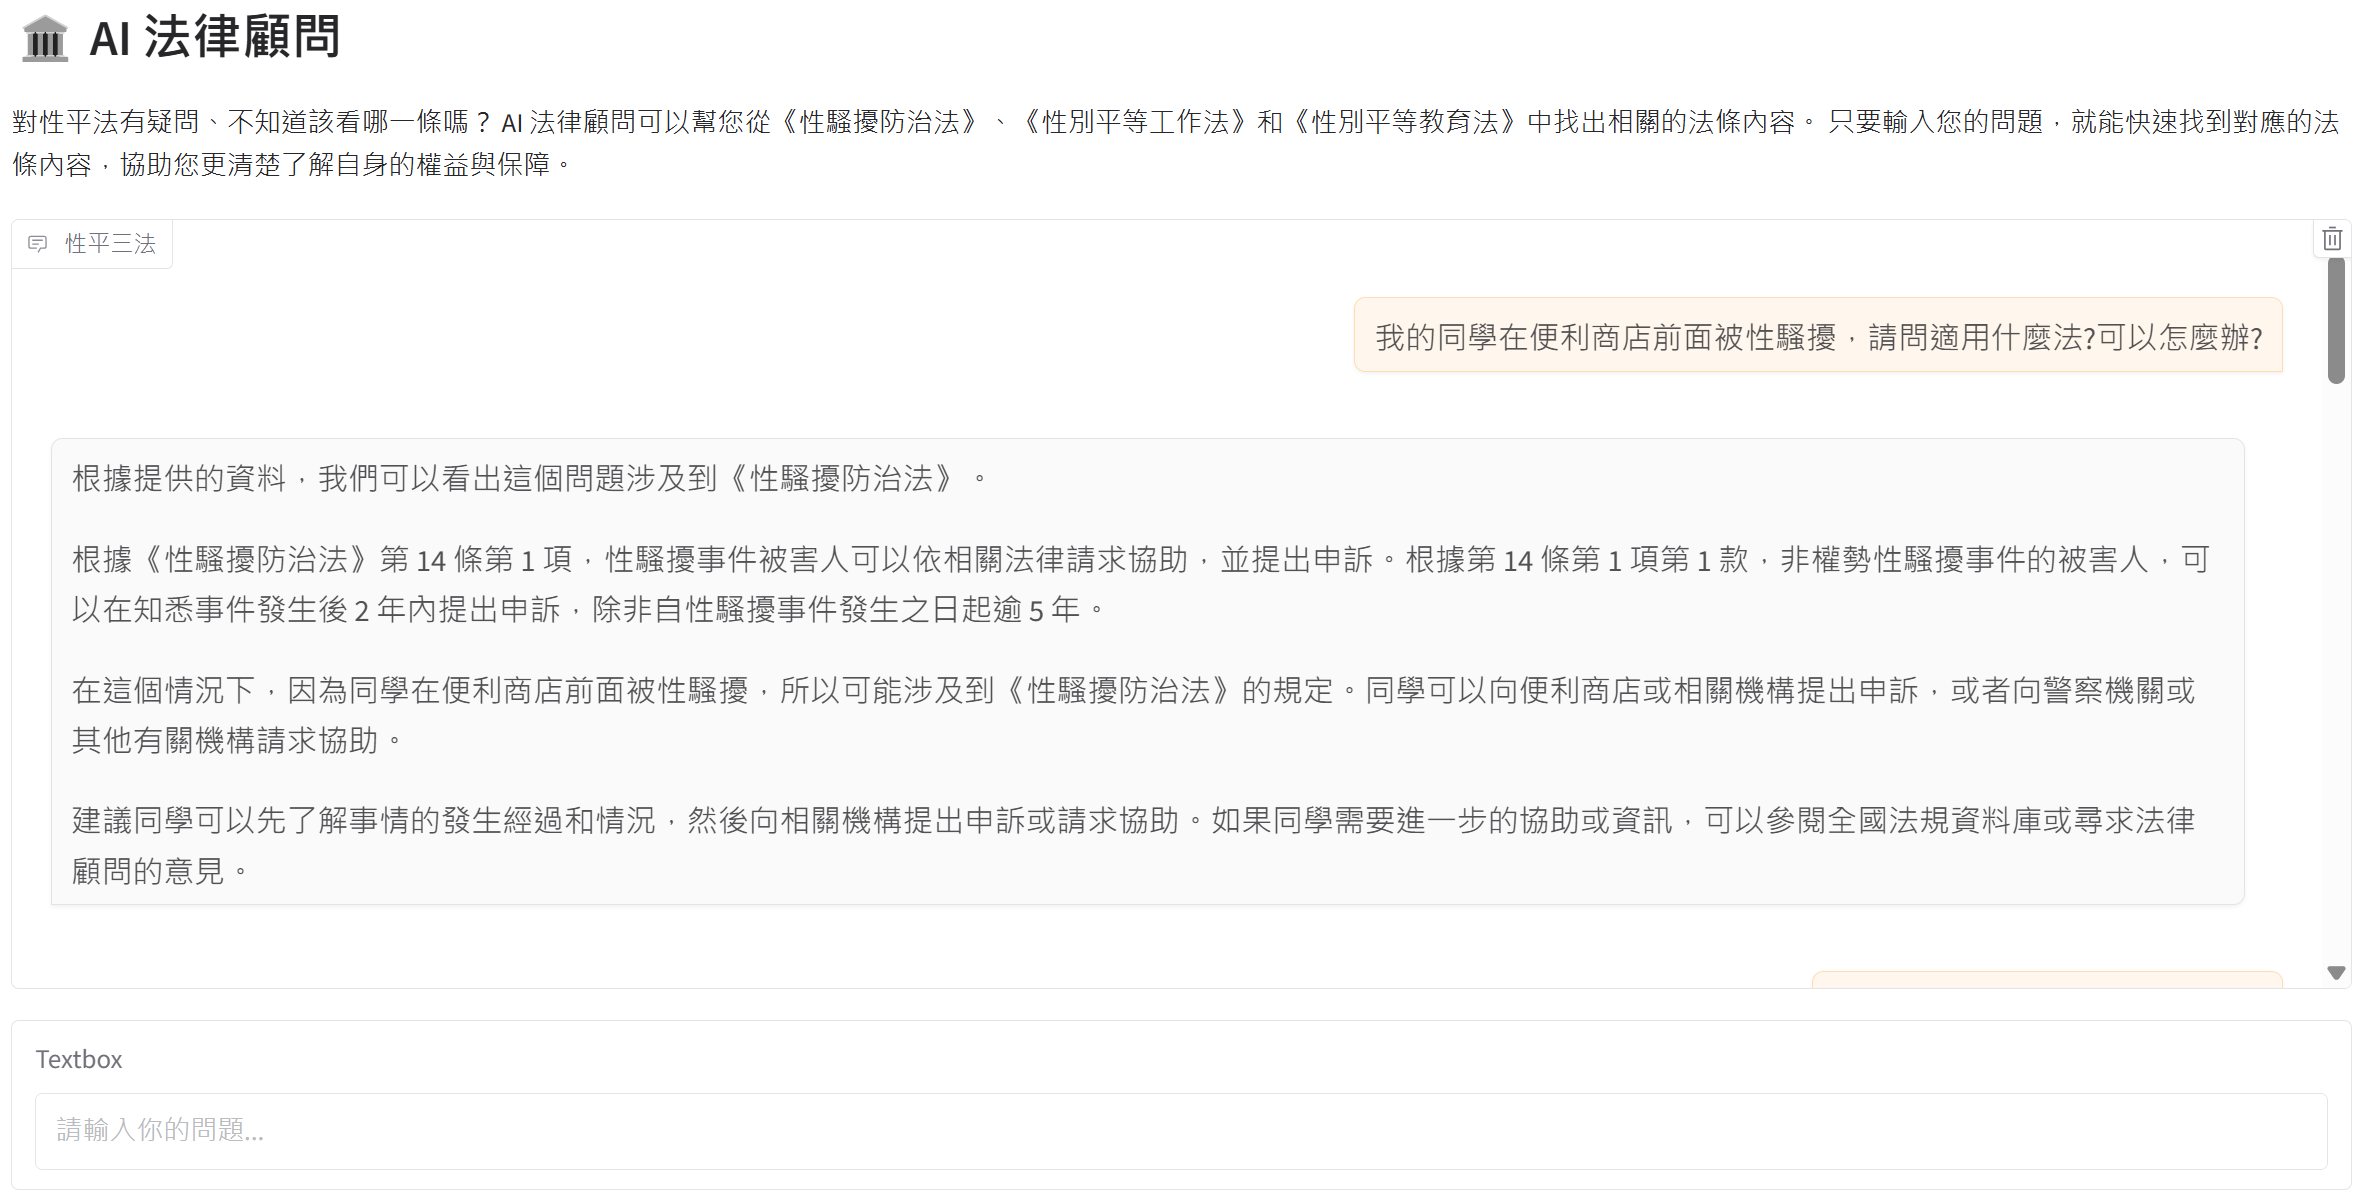